# Plot filtered tf corrected external data ps

In [1]:
import matplotlib.pyplot as plt
from pixell import reproject, enmap, utils, enplot
import numpy as np
import healpy as hp
import pymaster as nmt
from scipy.optimize import curve_fit

In [2]:
%matplotlib inline

#### Parameters

In [3]:
# SO SAT band used only for filtering and tf correction of the external data
fsat = '090'
SATp_type = '3'

# external data band to be used
fwmap = '023'
band_wmap = 'K'

In [4]:
# bins
binning_file = '/scratch/gpfs/SIMONSOBS/sat-iso/transfer_function/soopercool_inputs/binning_car_lmax2160_deltal15_large_first_bin.npz'
i_max_bin = 40  # kept only the first i_max_bin bins

In [5]:
# filtered cls
dir_cells = f'/scratch/gpfs/SIMONSOBS/users/ar3186/external_data/filtered_data/wmap/hm_0_1/satp{SATp_type}/f{fwmap}/soopercool_outputs/cells/'
data_ext_label = f'wmap_{band_wmap}_filtered_SATp{SATp_type}_f{fsat}_south_science'
data_ext_label_w_fband = f'wmap_f{fwmap}_filtered_SATp{SATp_type}_f{fsat}_south_science'

In [6]:
# fiducial cmb
fiducial_cmb = '/scratch/gpfs/SIMONSOBS/users/ar3186/common/camb_spectra/cls_planck_TT_EE_BB_TE.fits'

In [7]:
# pix win to correct for
lmax_pix_win = 10000
pix_win_data_sat = np.ones(lmax_pix_win)
pix_win_data_ext = hp.pixwin(2048, pol=True, lmax=lmax_pix_win)[1]  # pix win in wmap data # TODO: check

In [8]:
# beam to correct for
path_bl_ext = f'/scratch/gpfs/SIMONSOBS/users/ar3186/external_data/data/wmap/beams/wmap_ampl_bl_{band_wmap}1_9yr_v5p1.txt'

In [9]:
mode = 'EE'
imode_cmb = 1 # position of the selected mode in the cmb file
lmax_plot = 600
colors = ['blue', 'orange', 'green']
type = 'cross'

In [10]:
### Parameters for initial external data
data_init_ext_label = f'wmap_{band_wmap}'
dir_initial_data = '/scratch/gpfs/SIMONSOBS/users/ar3186/external_data/data'
exp = 'wmap'
nside = 512
res = 1.0

### geometry template 
# (used to reproject the initial maps in the same geometry as the filtered coadded maps)
path_iso_geometry_template = '/home/ar3186/pwg-scripts/iso-sat-review/mapmaking/band_car_fejer1_5arcmin.fits'

### iso-sat analysis mask
# (used in soopercool to compute the TF corrected filtered coadded data ps)
path_iso_analysis_mask = f'/scratch/gpfs/SIMONSOBS/sat-iso/transfer_function/satp{SATp_type}/south/soopercool_outputs/science/masks/analysis_mask.fits'

path_maps_initial_data_hp_A = f'{dir_initial_data}/{exp}/maps/{exp}_hp_{band_wmap}_bundle0_nside{nside}_coords_c.fits'
path_maps_initial_data_hp_B = f'{dir_initial_data}/{exp}/maps/{exp}_hp_{band_wmap}_bundle1_nside{nside}_coords_c.fits'

#### Get pix win and beams to correct for

Note: as the beam for Planck is available to ell=1537 and as we are not interested to the small ells, each time that I use binning_edges (low, centers or high) or the cls I cut them at around 40.

In [11]:
binning_edges = np.load(binning_file)
bin_centers_int = np.array(binning_edges['bin_center'][:i_max_bin], dtype=int)  # NOTE: this is exact only if bin centers are all integer values

In [12]:
bl_ext = np.loadtxt(path_bl_ext, usecols=(0, 1), unpack=True)[1]

In [13]:
bl_ext_centers = bl_ext[bin_centers_int]
pix_win_data_sat_centers = pix_win_data_sat[bin_centers_int]
pix_win_data_ext_centers = pix_win_data_ext[bin_centers_int]

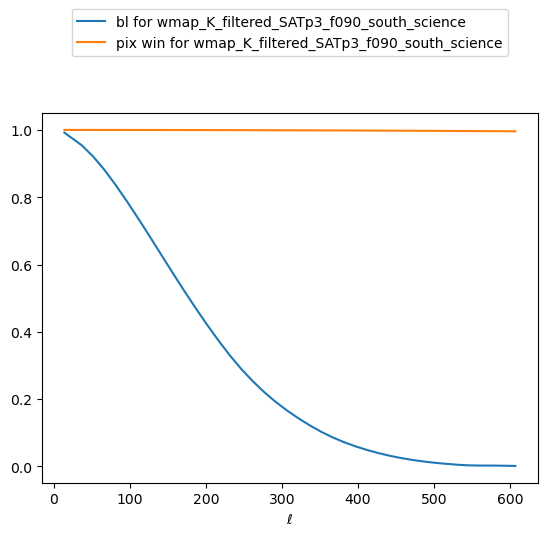

In [14]:
plt.plot(bin_centers_int, bl_ext_centers, label=f'bl for {data_ext_label}')

plt.plot(bin_centers_int, pix_win_data_ext_centers, label=f'pix win for {data_ext_label}')

plt.xlabel(r'$\ell$')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.3))

#### Get fiducial LCDM CMB

In [15]:
nmt_bins = nmt.NmtBin.from_edges(binning_edges["bin_low"][:i_max_bin], binning_edges["bin_high"][:i_max_bin] + 1)
lmax_bins = nmt_bins.get_ell_max(nmt_bins.get_n_bands() - 1)

In [16]:
cmb_cl = hp.read_cl(fiducial_cmb)[imode_cmb, :lmax_bins+1]
cmb_clb = nmt_bins.bin_cell(cmb_cl)

#### Get cls external data before filtering

In [17]:
# Maps initial external data full sky in hp
maps_initial_data_hp_A = hp.read_map(path_maps_initial_data_hp_A, field=(0,1,2))
maps_initial_data_hp_B = hp.read_map(path_maps_initial_data_hp_B, field=(0,1,2))

In [18]:
# reproject the initial hp map to car with the geometry from the iso template (band and 5amin) in car
shape, wcs = enmap.read_map_geometry(path_iso_geometry_template)
maps_initial_data_car_isogeo_A = reproject.healpix2map(maps_initial_data_hp_A, shape=shape, wcs=wcs)
maps_initial_data_car_isogeo_B = reproject.healpix2map(maps_initial_data_hp_B, shape=shape, wcs=wcs)

In [19]:
# load iso-sat analysis mask
analysis_mask_car = enmap.read_map(path_iso_analysis_mask)

In [20]:
# compute ps for initial external data in car and with the iso-sat geometry
field_pol_A = nmt.NmtField(mask=analysis_mask_car, maps=[maps_initial_data_car_isogeo_A[1], maps_initial_data_car_isogeo_A[2]], wcs=wcs, lmax=lmax_bins, lmax_mask=lmax_bins)
field_pol_B = nmt.NmtField(mask=analysis_mask_car, maps=[maps_initial_data_car_isogeo_B[1], maps_initial_data_car_isogeo_B[2]], wcs=wcs, lmax=lmax_bins, lmax_mask=lmax_bins)
cls_initial_pol = (nmt.compute_full_master(field_pol_A, field_pol_B, nmt_bins))

### Plot all cls : with beam corrections

(1e-06, 1000.0)

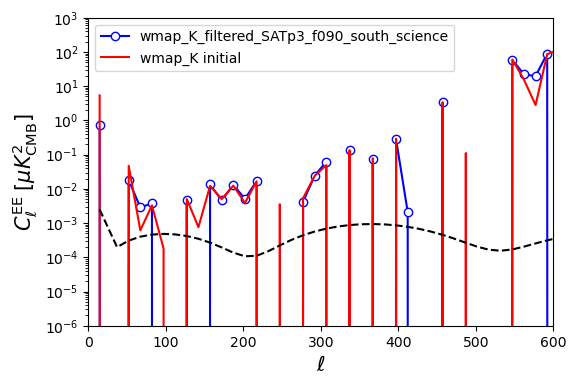

: 

In [ ]:
plt.figure(figsize=(6, 4))
plt.xlabel(r"$\ell$", fontsize=15)
plt.ylabel(r"$C_\ell^\mathrm{%s} \; [\mu K_\mathrm{CMB}^2]$" % mode,
            fontsize=15)

path_cls_filtered_coadded_tf = f'decoupled_{type}_pcls_{data_ext_label_w_fband}_x_{data_ext_label_w_fband}.npz'
cls_filtered_coadded_tf = np.load(dir_cells + path_cls_filtered_coadded_tf)

plt.plot(cls_filtered_coadded_tf['lb'][:i_max_bin], 
         cls_filtered_coadded_tf[mode][:i_max_bin]/pix_win_data_ext_centers**2/bl_ext_centers**2, 
         label = f'{data_ext_label}',   #x {data_ext_label}
         mfc="w", marker="o", c=colors[0])

plt.plot(cls_filtered_coadded_tf['lb'][:i_max_bin], 
         cls_initial_pol[0]*1e12/pix_win_data_ext_centers**2/bl_ext_centers**2, 
         label=f'{data_init_ext_label} initial',    #x {data_init_ext_label} 
         color='red')

plt.plot(cls_filtered_coadded_tf['lb'][:len(cmb_clb)], cmb_clb, c="k", ls="--")

plt.legend(fontsize=10)
# plt.title(f'{mode}', fontsize=15)
# plt.xscale('log')
plt.yscale('log')
plt.xlim(0, 600)
#lmax)
plt.ylim(1e-6, 1e3)